In [120]:
from google.cloud import vision
import io
import glob
import os
import os.path
import cv2
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output, Image, display
from io import BytesIO
import PIL.Image
###### before running, please run export GOOGLE_APPLICATION_CREDENTIALS='/path/to/your/client_secret.json'
#export GOOGLE_APPLICATION_CREDENTIALS='/c/Users/poorv/Downloads/ocr_scripts/keys/direct-outlook-270501-c05c2d97d1c6.json'
#echo $GOOGLE_APPLICATION_CREDENTIALS 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/poorv/Downloads/ocr_scripts/keys/direct-outlook-270501-c05c2d97d1c6.json"

In [211]:
def di(*args):
    fig2 = plt.figure(figsize = (15,10)) # create a 5 x 5 figure 
    num_args = len(*args)
    imgs = args[0]
    if num_args == 1:
        plt.subplot(111)
        plt.imshow(imgs[0],cmap = 'gray')
    elif num_args == 2:
        plt.subplot(121)
        plt.imshow(imgs[0],cmap = 'gray')
        plt.subplot(122)
        plt.imshow(imgs[1],cmap = 'gray')
    else:
        #i.e. 3 images
        plt.subplot(131)
        plt.imshow(imgs[0],cmap = 'gray')
        plt.subplot(132)
        plt.imshow(imgs[1],cmap = 'gray')
        plt.subplot(133)
        plt.imshow(imgs[2],cmap = 'gray')
        
    plt.show()

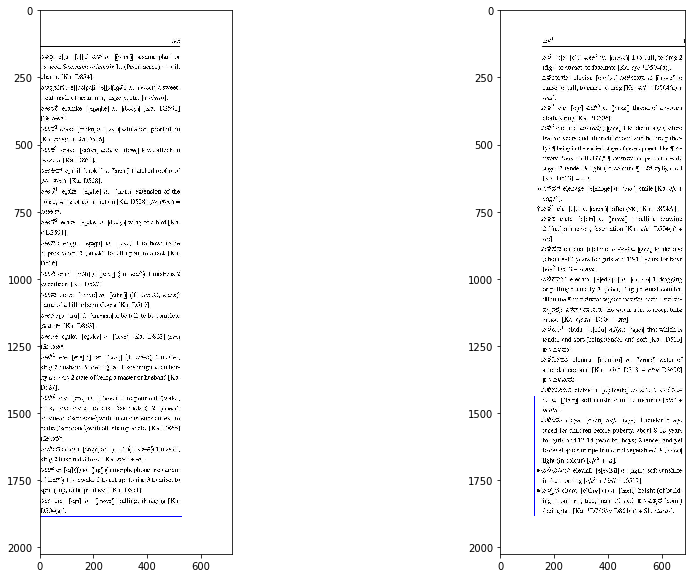

In [215]:
imgs = (right, left)
di(imgs)

[array([[ 264, 1833,  264,  134]], dtype=int32), array([[ 308, 1791,  308,  134]], dtype=int32), array([[ 634, 1875,  634,  134]], dtype=int32), array([[ 280, 1871,  280,  134]], dtype=int32), array([[ 601, 1867,  601,  134]], dtype=int32), array([[ 864, 1839,  864,  134]], dtype=int32), array([[ 737, 1870,  737,  134]], dtype=int32), array([[ 162, 1871,  162,  115]], dtype=int32), array([[ 585, 1863,  585,  134]], dtype=int32), array([[ 628, 1863,  628,  134]], dtype=int32), array([[ 514, 1865,  514,  134]], dtype=int32), array([[ 729, 1870,  729,  134]], dtype=int32), array([[ 804, 1875,  804,  134]], dtype=int32), array([[ 287, 1866,  287,  134]], dtype=int32), array([[1096, 1831, 1096,  134]], dtype=int32), array([[ 479, 1866,  479,  134]], dtype=int32), array([[ 980, 1826,  980,  134]], dtype=int32), array([[ 426, 1853,  426,  134]], dtype=int32), array([[ 452, 1741,  452,  134]], dtype=int32), array([[ 727, 1871,  727,  134]], dtype=int32), array([[ 826, 1838,  826,  134]], dtype

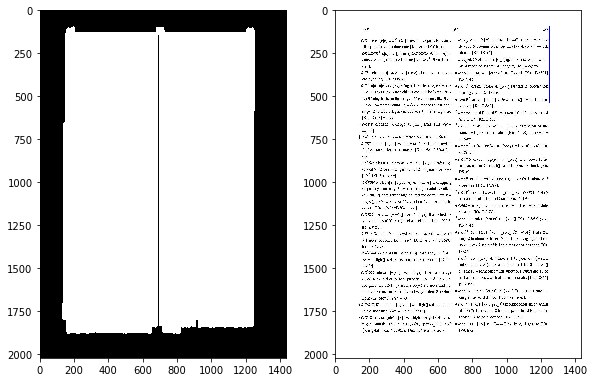

In [156]:
pg188 = "jpgs/output-190-to-190.jpg"
os.path.isfile(pg188)
tc = cv2.imread(pg188) 
fig2 = plt.figure(figsize = (15,10)) # create a 5 x 5 figure 

im = tc.copy()
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(im_gray,127,255,cv2.THRESH_BINARY_INV)
thresh = cv2.GaussianBlur(thresh,(1, 1),0)
edges = cv2.Canny(thresh,50,100,apertureSize = 3)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 1  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 1  # minimum number of pixels making up a line
max_line_gap = 1000  # maximum gap in pixels between connectable line segments
# line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

vert_line = []
vert_avg = 0
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(thresh,(x1,y1),(x2,y2),(255,0,0),15)
        if x1 == x2:
            vert_avg+=x1
            vert_line.append(line)

print(vert_line)
        
struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
thresh = cv2.dilate(thresh, struct, anchor=(-1, -1), iterations=100)

contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
minArea=2000 #nothing 
for cnt in contours:
    area=cv2.contourArea(cnt)
    if(area>minArea):
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(im,[box],0,(0,0,255),1)

        
plt.subplot(131)
# plt.imshow(edges,cmap = 'gray')
plt.imshow(thresh,cmap = 'gray')
# plt.subplot(133)
plt.subplot(132)
# plt.subplot(111)
# plt.subplot(131)
plt.imshow(im,cmap = 'gray')
plt.show()

In [123]:
av = vert_avg/len(vert_line)

In [126]:
height, width, channels = im.shape
right = im[0:height, int(width/2):width] #this line crops\n",
left = im[0:height, 0:int(av)]


# OCR

In [121]:
def dtlh(path, lh):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.text_detection(
    image=image,
    image_context={"language_hints": lh},  # Bengali
    )
    texts = response.text_annotations
    print(texts[0].description)
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [122]:
dtlh(pg188, ["kn"])

ಎಳೆ!
162
ಎಟಿ
ಎಳೆ ele [ele] ಎಳೆ 1 vt. [move] 1 to pull, to drag ? ಎಳ್ಳು ellu [೬]]u] ಎಲ್ 12, plant] Sesame plant of
(fg) to attract, to fascinate [Ka. ere *D504(a)]. its Seed Sesaru?? orterstate L. (Pedaliaceae) - oil,
ಎಳೆಯಿಸು' eleyisu [elejisu] ಎಳೆಯಿಸು vt. [move] to pharm, [Ka. D854].
cause to pull, to cause to drag [Ka. ಎಳೆ *D504(a) + ಎಳ್ಳುಚಿಗಳಿ ellucigali [ellutigali] ft. [sweet] a Sweet-
-{S),
Imeat made of sesamurm, jaggery, etc. [+ cigatt].
ಎಳೆ² ele [ele] ಎಳೆ 2 , [three] thread of a woven oಎಅಂಕೆ erarmke [erarke] , [body) [Ka. D2591]
cloth, string [Ka. *D506].
_IE ಎಕೆ.
ಎಳೆ' ele [ele] ಎಳ (adj.) [age] 1 tender in age (before 'ಎಟಕ ಅtaka [erake] 7. [soc.] salutation, prostration
twelve years and after childhood and before puber- [Ka. eragu + -ka D516].
ty) – being in the earliest stage of development, like [ ಎ- ಎಂಕಿ eraka [erske] ಎರಕ 12. [love] love, affection
ಮಗು “very small child,” T ಎಳೆಗಾಯಿ unripe fruit in early (Pb.8.23) [Ka. D862].
stage 2 tender 3 light (in colour) • ಎಳೆಗೆಂಪು ligh

In [45]:
import os
import cv2
# import imutils

# This only works if there's only one table on a page
# Important parameters:
#  - morph_size
#  - min_text_height_limit
#  - max_text_height_limit
#  - cell_threshold
#  - min_columns

def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    # OpenCV 3
    # img, contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes


def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells